In [1]:
import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import matplotlib as mpl

## ADCIRC Run

In [2]:
super = '../staging/runs/Matthew2016_SWAN/' 
root = super+'adcirc+swan/'

In [3]:
## load the NetCDF dataset from a specified file path
nc = netcdf.Dataset(root+'maxele.63.nc', 'r')

Text(0.5, 1.0, 'Maxele.63.nc')

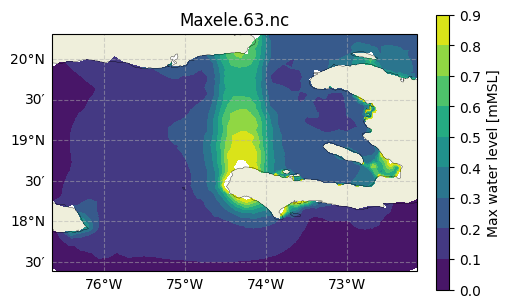

In [4]:
## generate a plot of the maximum water levels
fig, ax = plt.subplots(figsize = (5,3), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
plot_nc(nc, 'zeta_max', levels = np.arange(0., 1., 0.1), background_map = True, cbar = True, cb_label = 'Max water level [mMSL]',
        ax = ax, fig = fig)
ax.set_title('Maxele.63.nc')

In [5]:
nc = netcdf.Dataset(root+'fort.63.nc', 'r')
nc2 = netcdf.Dataset(root+'fort.74.nc', 'r')

xlims = [-74.5, -72.62]
ylims = [18., 20.]

ele_array = nc.variables['zeta'][:]
print('Min: ' + str(ele_array.min()))
print('Avg: ' + str(ele_array.mean()))
print('Max: ' + str(ele_array.max()))

Min: -2.6513661015746797
Avg: 0.006003279764426835
Max: 1.9664094532509309


Text(0.5, 1.0, 'ADCIRC Run - fort.63.nc at timestep: 10')

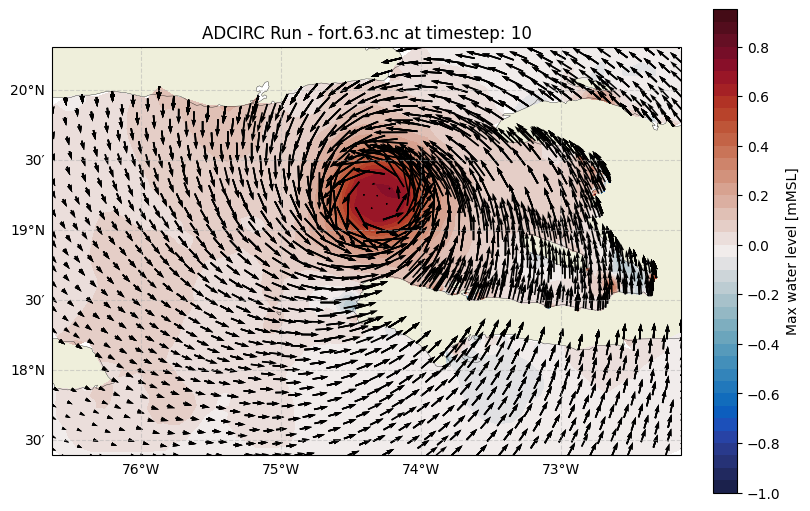

In [6]:
timestep = 10
fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
plot_nc(nc, 'zeta', levels = np.arange(-1., 1., 0.05), background_map = True, cbar = True, cb_label = 'Max water level [mMSL]', cmap = cmocean.cm.balance, ts = timestep,
        ncvec = nc2, dxvec=0.05, dyvec=0.05, vecsc=700, ax = ax, fig = fig)
ax.set_title('ADCIRC Run - fort.63.nc at timestep: '+str(timestep))

In [7]:
xs = [-74.2, -73.5, -72.9, -72.8]
ys = [19.3133, 19.3133, 19.3133, 19.3133]

Remember that you had to edit the Kalpana source code for this extract_ts_from_nc to work with those files (adding extra split for ! NCD present in file). Remember to put in a pull request.

Text(0, 0.5, 'Water level [m MSL]')

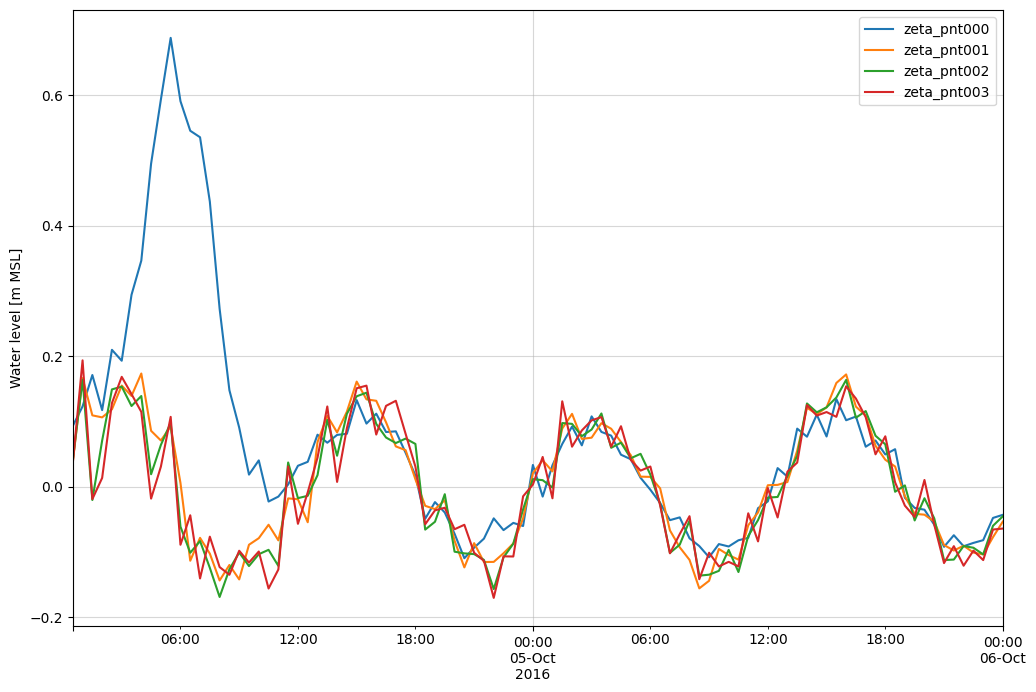

In [8]:
dfout, rep = extract_ts_from_nc(nc, list(zip(xs, ys)), variable = 'zeta', extractOut=False, closestIfDry=False)

fig, ax = plt.subplots(figsize = (12, 8))
dfout.plot(ax = ax)
ax.grid(alpha = 0.5)
ax.set_ylabel('Water level [m MSL]')

## ADCIRC+SWAN Run

In [9]:
super_shift = '../staging/runs/Matthew2016_SWAN_mod/'
root_swan = super_shift+'adcirc+swan/'

In [ ]:
## load the NetCDF dataset from a specified file path
nc_swan = netcdf.Dataset(root_swan+'fort.63.nc', 'r')
nc2 = netcdf.Dataset(root_swan+'fort.74.nc', 'r')

Text(0.5, 1.0, 'ADCIRC+SWAN - fort.63.nc at timestep: 10')

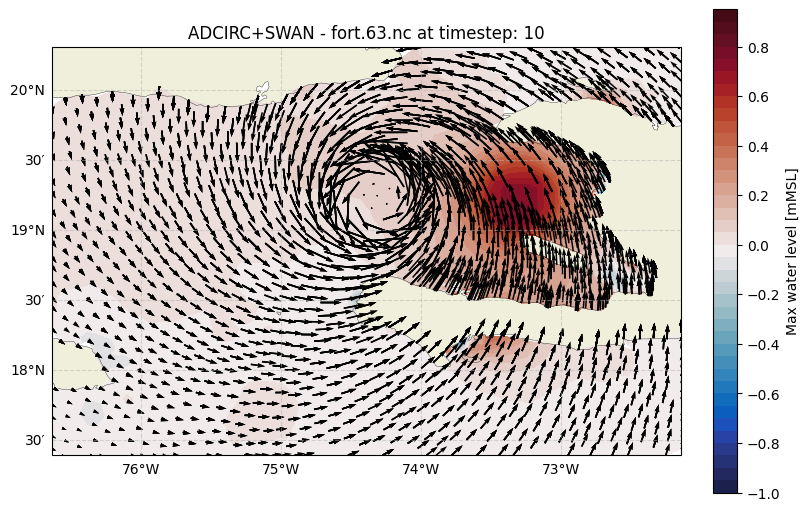

In [11]:
fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
plot_nc(nc_swan, 'zeta', levels = np.arange(-1., 1., 0.05), background_map = True, cbar = True, cb_label = 'Max water level [mMSL]', cmap = cmocean.cm.balance, ts = timestep,
        ncvec = nc2, dxvec=0.05, dyvec=0.05, vecsc=700, ax = ax, fig = fig)
ax.set_title('ADCIRC+SWAN - fort.63.nc at timestep: '+str(timestep))

In [12]:
nc_HS = netcdf.Dataset(root_swan+'swan_HS.63.nc', 'r')

variables = list(nc_HS.variables.keys())
swan_HS_list = nc_HS.variables['swan_HS'][:]
print('Min: ' + str(swan_HS_list.min()))
print('Avg: ' + str(swan_HS_list.mean()))
print('Max: ' + str(swan_HS_list.max()))

Min: 0.0
Avg: 2.2310902378074142
Max: 14.37878131866455


<GeoAxesSubplot: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>

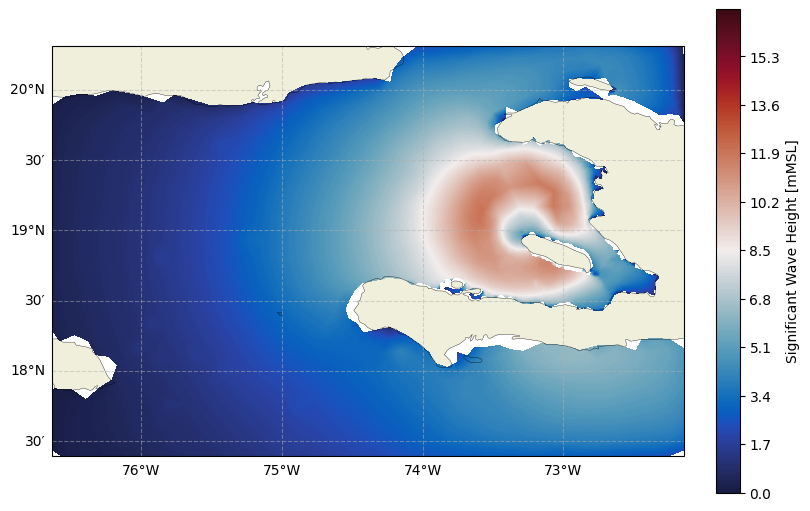

In [13]:
fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 17., 0.05),
        background_map = True, cbar = True, cb_label = 'Significant Wave Height [mMSL]',
        cmap = cmocean.cm.balance, ts = 10, ax = ax, fig = fig)

Text(0, 0.5, 'Water level [m MSL]')

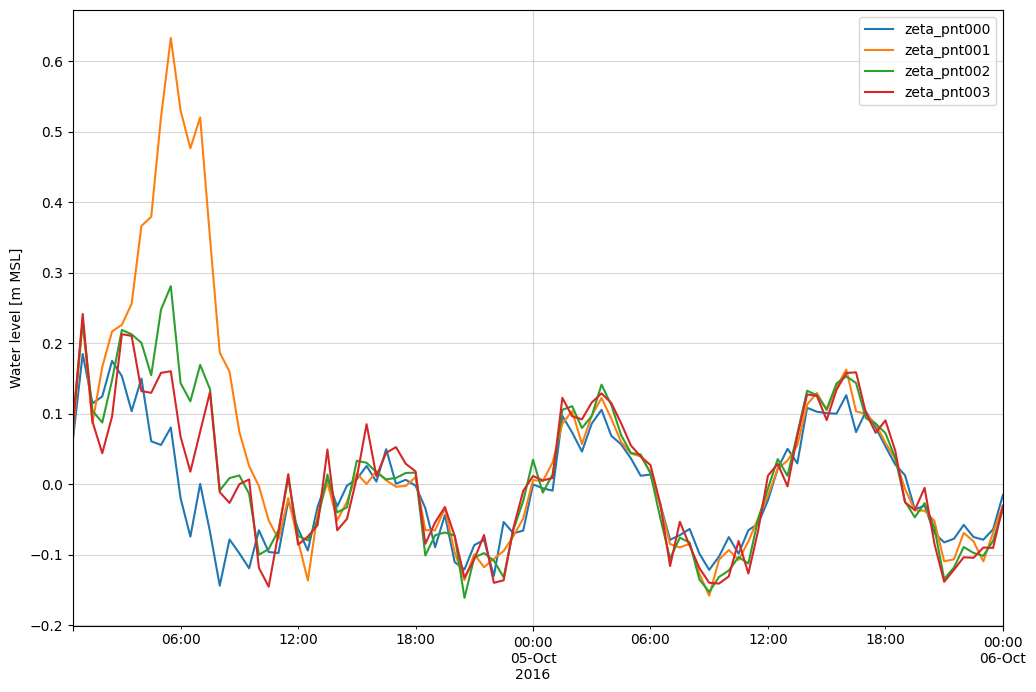

In [14]:
dfout2, rep = extract_ts_from_nc(nc_swan, list(zip(xs, ys)), variable = 'zeta', extractOut=False, closestIfDry=False)

fig, ax = plt.subplots(figsize = (12, 8))
dfout2.plot(ax = ax)
ax.grid(alpha = 0.5)
ax.set_ylabel('Water level [m MSL]')

## Water Level Comparison

Text(0.5, 1.0, 'Comparison of water levels at site: zeta_pnt002')

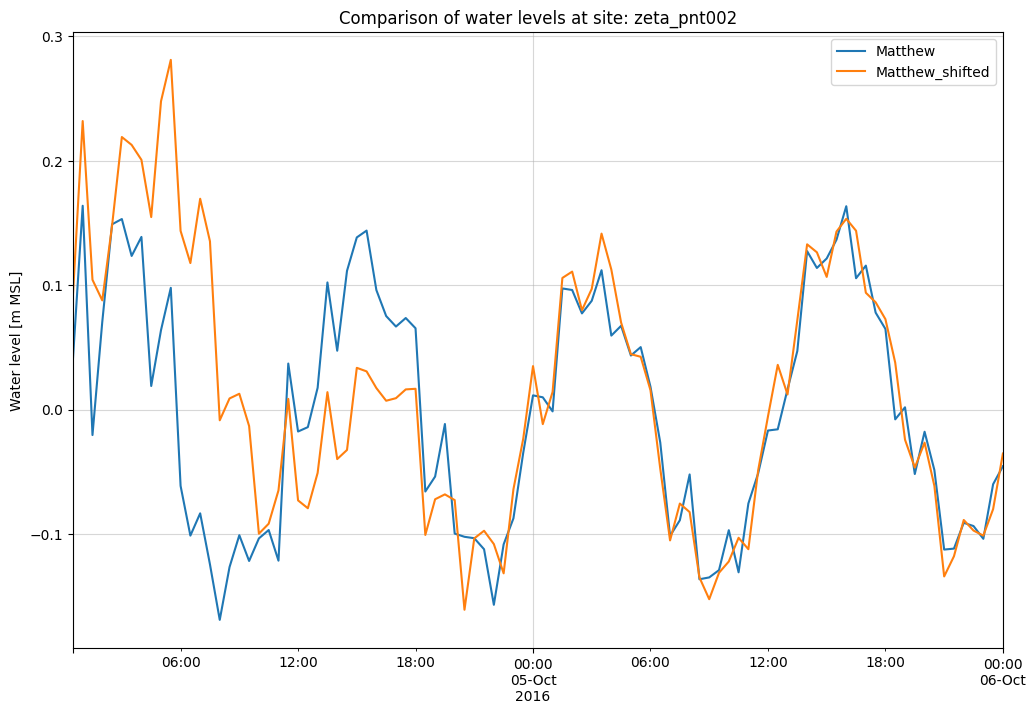

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
site_id = 2
site_name = 'zeta_pnt00' + str(site_id)
dfout[site_name].plot(ax = ax)
dfout2[site_name].plot(ax = ax)
ax.grid(alpha = 0.5)
ax.legend(['Matthew', 'Matthew_shifted'])
ax.set_ylabel('Water level [m MSL]')
ax.set_title('Comparison of water levels at site: ' + site_name)

## Animation

In [16]:
from matplotlib.animation import FuncAnimation

In [ ]:
title = 'ADCIRC+SWAN_HS_shifted.gif'#ADCIRC+SWAN_HS.gif'
data = nc_HS #nc_swan  
var = 'swan_HS' #'zeta'#'swan_HS' 

for i in tqdm(range(95), desc="Generating frames"):
        n = plot_nc(data, var, 
                levels = np.arange(0, 15., 0.05), 
                background_map = True, 
                cbar = True, 
                cb_label = 'Max water level [mMSL]', 
                cmap = cmocean.cm.balance, 
                ts = i,  # Use frame as timestep
                xlims=xlims, 
                ylims=ylims,
                ncvec = nc2, 
                dxvec=0.05, 
                dyvec=0.05, 
                vecsc=700)  # Pass the axis to plot on
        
        # Add frame number for reference
        n.set_title(f'Timestep {i}')
        fig = n.figure
        # Save the frame
        frame_file = f'animation/ts_{i}.png'
        fig.savefig(frame_file, dpi=500, bbox_inches='tight')
        plt.close(fig)

Generating frames: 100%|██████████| 95/95 [01:51<00:00,  1.17s/it]


In [18]:
import imageio
import os

def create_animation_with_imageio():
    print("Creating animation with imageio...")
    
    # Get all frame files
    frames = []
    for ts in range(95):
        frame_file = f'animation/ts_{ts}.png'
        if os.path.exists(frame_file):
            frames.append(frame_file)
        else:
            print(f"Warning: File {frame_file} does not exist!")
    
    if not frames:
        print("No frames found!")
        return
    
    print(f"Found {len(frames)} frames")
    
    # Create GIF
    images = []
    for frame in frames:
        try:
            images.append(imageio.imread(frame))
        except Exception as e:
            print(f"Error reading {frame}: {str(e)}")
    
    if images:
        print(f"Creating GIF with {len(images)} images")
        imageio.mimsave(title, images, fps=12, loop=0)
        print("Animation saved to " + title)
    else:
        print("No images could be loaded")

# Try the alternative method
try:
    import imageio
    create_animation_with_imageio()
except ImportError:
    print("imageio not installed. Try: pip install imageio")

Creating animation with imageio...
Found 95 frames
Creating GIF with 95 images
Animation saved to ADCIRC+SWAN_HS_shifted.gif


## Station Locations

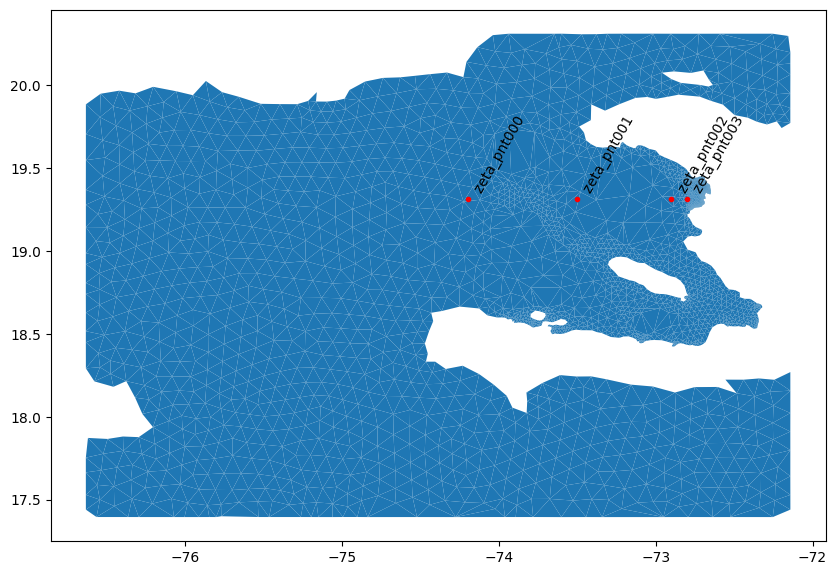

In [19]:
mesh = fort14togdf(root+'/fort.14', epsgIn=4326, epsgOut=4326, fileintype='fort.14')
fig, ax = plt.subplots(figsize = (10,8))
mesh.plot(ax = ax)
ax.scatter(xs, ys, color = 'r', marker = '.')

stations = dfout.columns.tolist()
for i, txt in enumerate(stations):
    ax.annotate('  '+txt, (xs[i], ys[i]), rotation=60)